kaggle: (https://www.kaggle.com/code/harshsingh2209/generating-brain-mri-images-with-dc-gan/notebook)

In [37]:
import os
import numpy as np
import cv2
import pandas as pd

import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [38]:
BATCH_SIZE = 16
EPOCHS = 100

In [39]:
class DCGAN_Dataset(Dataset):
    def __init__(self, transform, mode):
        self.transform = transform
        self.image_folder, self.mask_folder = [], []
        categories = ['benign', 'normal', 'malignant']
        
        for i, category in enumerate(categories):
            image_files = sorted([category+'/'+f for f in os.listdir(category) if "mask" not in f.lower()])
            mask_files = sorted([category+'/'+f for f in os.listdir(category) if "mask" in f.lower()])
            train_size = int(len(image_files)*0.8)
            if mode == 'train':
                self.image_folder.extend(image_files[:train_size])
                self.mask_folder.extend(mask_files[:train_size])
            else:
                self.image_folder.extend(image_files[train_size:])
                self.mask_folder.extend(mask_files[train_size:])
        
    def __len__(self):
        return len(self.image_folder)
    
    def __getitem__(self, idx):
        img_path, mask_path = self.image_folder[idx], self.mask_folder[idx]
        img, mask = cv2.imread(img_path), cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        img, mask = img/255.0, mask/255.0
        img, mask = self.transform(img), self.transform(mask)
        
        return (img, mask)
        

In [40]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((256,256))])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((256,256))])
train_set = DCGAN_Dataset(transform=train_transforms, mode='train')
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_set = DCGAN_Dataset(transform=test_transforms, mode='test')
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [41]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        efficientnet = models.efficientnet_b0(weights='IMAGENET1K_V1')
        self.encoder = efficientnet.features
        
    def forward(self, x):
        x = self.encoder(x)
        return x

In [42]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dconv1 = nn.ConvTranspose2d(1280, 256, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        self.dconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.dconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.dconv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.dconv5 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(16)
        
        self.conv1 = nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.bn1(self.dconv1(x)))
        x = self.relu(self.bn2(self.dconv2(x)))
        x = self.relu(self.bn3(self.dconv3(x)))
        x = self.relu(self.bn4(self.dconv4(x)))
        x = self.relu(self.bn5(self.dconv5(x)))
        
        x = self.sigmoid(self.bn6(self.conv1(x)))
        
        return x

In [43]:
class DCGANNet(nn.Module):
    def __init__(self):
        super(DCGANNet, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

In [44]:
import torch.optim as optim
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

model = DCGANNet().to(device)

criterion = nn.BCELoss()
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)

In [45]:
for epoch in range(EPOCHS):
    for i, (imgs, masks) in enumerate(train_loader):
        imgs = imgs.float().to(device)
        masks = masks.float().to(device)

        model.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()


    if epoch%10==0:
        print(f"[{epoch}/{EPOCHS}][{i}/{len(train_loader)}]  Loss: {loss.item():.4f}")

[0/100][38/39]  Loss: 0.6494
[10/100][38/39]  Loss: 0.5499
[20/100][38/39]  Loss: 0.5407
[30/100][38/39]  Loss: 0.4556
[40/100][38/39]  Loss: 0.4297
[50/100][38/39]  Loss: 0.4612
[60/100][38/39]  Loss: 0.4196
[70/100][38/39]  Loss: 0.3945
[80/100][38/39]  Loss: 0.3469
[90/100][38/39]  Loss: 0.3556


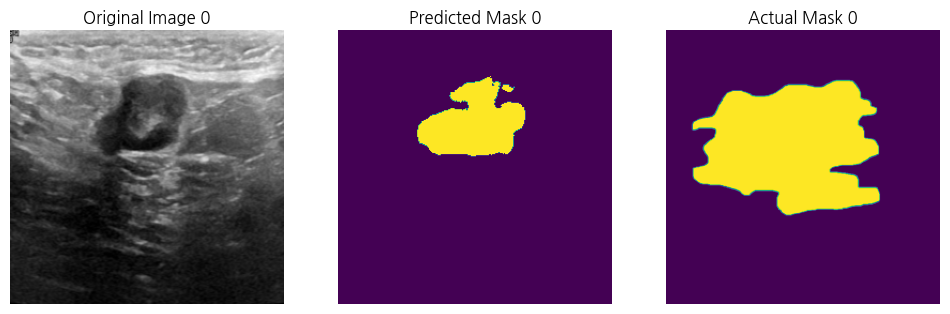

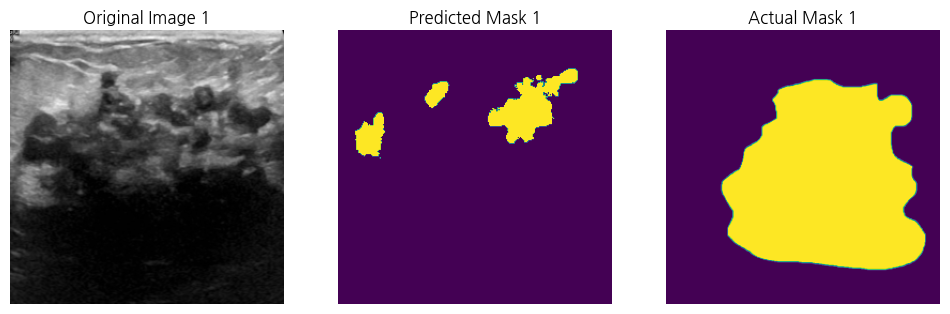

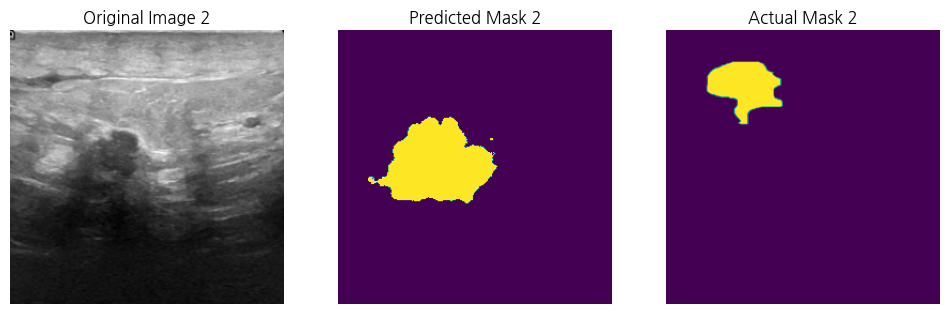

In [46]:
def plot_sample(image, predicted_mask, actual_mask, index):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title(f'Original Image {index}')
    ax[0].axis('off')

    ax[1].imshow(predicted_mask, cmap='viridis')
    ax[1].set_title(f'Predicted Mask {index}')
    ax[1].axis('off')

    ax[2].imshow(actual_mask, cmap='viridis')
    ax[2].set_title(f'Actual Mask {index}')
    ax[2].axis('off')

    plt.show()

test_imgs, test_masks, test_preds = [], [], []
with torch.no_grad():
    for imgs, masks in test_loader:
        test_imgs = imgs.float().to(device)
        test_masks = masks.float().to(device)

        predictions = model(test_imgs)
        test_preds = (predictions > 0.5).cpu().numpy().astype(np.uint8)

for i in range(3):  # Show 3 samples
    plot_sample(test_imgs[i].permute(1,2,0).cpu(), test_preds[i].squeeze(), test_masks[i].cpu().squeeze(), i)